In [1]:
# to generate paper tables and figures
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import pathlib

In [2]:
def get_df(full_dir):
    if os.path.isfile(full_dir):
        this_df = pd.read_excel(full_dir)
        if 'Unnamed: 0' in this_df.columns:
            this_df.drop(columns = 'Unnamed: 0', inplace = True)
        return this_df
    else:
        return None

def get_test_df(result_dir):
    sub_dir_list = [x for x in os.listdir(result_dir) if len(x.split('.'))==1]
    out_of_sample_list = []
    test_list = []
    # we select the model with the smallest loss
    # for 
    metric_column = "loss"
    model_index_list = []
    test_ratio_list = []
    price_movement_count_list = []
    full_ratio_list = []
    period_df_list = []
    for sub_dir in sub_dir_list:
        result_root_dir = os.path.join(result_dir, sub_dir)
        this_file = os.path.join(result_root_dir, "pretrained_model_accuracy_out_of_sample.xlsx")
        out_of_sample_df = get_df(this_file)
        lr_file = os.path.join(result_root_dir, "model","learning_rate.xlsx")
        lr_df = get_df(lr_file)
        out_of_sample_df["sub_dir"] = sub_dir
        out_of_sample_df['lr'] = lr_df.loc[0].tolist()
        model_index = out_of_sample_df[metric_column].idxmin()
        # model_index = out_of_sample_df['auc'].idxmax()
        model_index_list.append(model_index)
        lr = lr_df[str(model_index)].tolist()[0]
        out_of_sample_list.append(out_of_sample_df.loc[model_index])
        this_file = os.path.join(result_root_dir, "pretrained_model_accuracy_test.xlsx")
        test_df = get_df(this_file)
        test_df["sub_dir"] = sub_dir
        test_df["lr"] = lr
        test_list.append(test_df.loc[model_index])
    # we select
    test_df = pd.DataFrame(test_list)
    out_of_sample_df = pd.DataFrame(out_of_sample_list)
    out_of_sample_df.columns = [x + "_out_of_sample" for x in out_of_sample_df.columns]
    test_df = test_df.merge(out_of_sample_df, left_on = "sub_dir", right_on = "sub_dir_out_of_sample", how = 'left')
    if len(test_ratio_list)>0:
        test_ratio_df = pd.DataFrame(test_ratio_list)
        test_ratio_df.columns = [x + "_test" for x in test_ratio_df.columns]
        test_df = test_df.merge(test_ratio_df, left_on = "sub_dir", right_on = "sub_dir_test", how = 'left')
    test_df.set_index("sub_dir", inplace = True)
    return test_df

In [3]:
# current_path = pathlib.Path(__file__).parent.absolute()
current_path = os.getcwd()
result_dir_root = os.path.join(current_path, 'simulation_pretrained_models')
folder_list = os.listdir(result_dir_root)
# full_index = [x.split(".")[0] for x in folder_list]
# pair_index = [x.split("-")[0] for x in full_index ]
# try:
#     trial_index  = [x.split("-")[1] for x in full_index ]
# except:
#     trial_index = [1] * len(pair_index)
merged_df_list = []
for folder in folder_list:
    print(folder)
    result_dir = os.path.join(result_dir_root, folder) 
    this_df = get_test_df(result_dir)
    merged_df_list.append(this_df)

1-1.csv
10-1.csv
2-1.csv
3-1.csv
4-1.csv
5-1.csv
6-1.csv
7-1.csv
8-1.csv
9-1.csv


In [4]:
# merge models
to_merge_list = ['ChannelwiseLSTM_two_groups', 'ChannelwiseLSTM_total_split', 
                'mGRN_two_groups', 'mGRN_total_split']
processed_df_list = []
for this_df in merged_df_list:
    processed_rows = [this_df.loc['LSTM'],this_df.loc['GRU']]
    for model in to_merge_list:
        index_list = [x for x in this_df.index if model in x]
        sub_df = this_df.loc[index_list]
        processed_row = sub_df.loc[sub_df['loss_out_of_sample'].idxmin()]
        processed_row.name = model
        processed_rows.append(processed_row)
    processed_df = pd.DataFrame(processed_rows)
    processed_df_list.append(processed_df)  
merged_df_list = processed_df_list

In [5]:
target_column_list= ['loss']
model_name_list = merged_df_list[0].index
df_list = []
for target_column in target_column_list:
    target_list = []
    for model_name in model_name_list:
        temp_list = []
        for merged_df in merged_df_list:
            this_serires = merged_df.loc[model_name]
            temp_list.append(this_serires[target_column])
        target_list.append(temp_list)
        # target_list.append(np.mean(temp_list))
    df = pd.DataFrame.from_records(target_list)
    df.index = model_name_list
    # df.columns = full_index
    df_list.append(df)
mean_dict = {}
for model_name in model_name_list:
    mean_list = []
    for df in df_list:
        mean_list.append(df.loc[model_name].mean())
    mean_dict[model_name] = mean_list[0]
    print(model_name + ": {:.2f}".format(mean_list[0]))
#######
# theoretical minimum
theoretical_minimum_df = pd.read_csv(os.path.join(current_path, 'simulation_data', 'data_generation_matlab', 
                                                  'theoretical_minimum_mse.csv'), header = None)
print("theoretical minimum mse: {:.2f}".format(theoretical_minimum_df[1].mean()))
#######

LSTM: 22.26
GRU: 22.20
ChannelwiseLSTM_two_groups: 22.06
ChannelwiseLSTM_total_split: 21.93
mGRN_two_groups: 21.91
mGRN_total_split: 21.88
theoretical minimum mse: 21.64


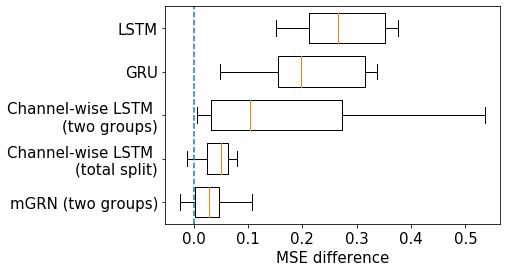

In [6]:
target_model =  'mGRN_total_split'
model_name_list = [x for x in model_name_list if x!=target_model]
model_name_list.reverse()
axe_label_dict = {'LSTM':'LSTM', 'GRU':'GRU', 
                  'ChannelwiseLSTM_two_groups':'Channel-wise LSTM \n(two groups)',
                  'ChannelwiseLSTM_total_split': 'Channel-wise LSTM \n(total split)',
                  'mGRN_two_groups': 'mGRN (two groups)',
                  'mGRN_total_split': 'mGRN\n(total split)',                
                 }
axe_labels = [axe_label_dict[x] for x in model_name_list]
font = {'size'   : 15}
matplotlib.rc('font', **font)
for metric_index, sub_df in enumerate(df_list):
    # fig = plt.figure(figsize =(4,3))
    fig_len = len(model_name_list)*0.6+1
    fig = plt.figure(figsize =(6,fig_len))
    ax = plt.axes()
    sub_df = sub_df - sub_df.loc[target_model]
    to_drop_index = [x for x in sub_df.index if x not in model_name_list]
    sub_df.drop(index = to_drop_index, inplace = True)
    bp = plt.boxplot(sub_df.loc[model_name_list], widths=0.7, showfliers=False, vert=False)
    ax.set_yticklabels(axe_labels)
    matplotlib.rcParams.update({'figure.autolayout': True})
    n_model = len(model_name_list)
    line_pos = [0.5] + list(range(1, n_model+1)) + [n_model+0.5]
    line, = plt.plot([0]*len(line_pos),line_pos,  '--')
    plt.xlabel('MSE difference', fontsize=15)
    plt.show()
